# Feature Detection

## Splitting Audio

In [15]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt

In [33]:
bufferSize = 1024
threshhold = 15
frontWrapperTimer = 0.1
endWrapperTimer = 0.1
samples = []

### Custom Class zum speichern eines Buffers
Die Bufferklasse speichert alle Samplewerte der Audiospur, die in der Länge des Buffers sind und die durchschnittliche Lautstärke des Buffers.

In [4]:
class Buffer:
    def __init__(self, values, loudness):
        self.value = values
        self.bufferLoudness = loudness

Iteriert einmal durch die gesamte Audiospur und teilt diese in n Buffer auf.

In [5]:
def HandleAudioBuffer():
    bufferCounter = 0
    bufferLoudness = 0
    allBuffers = []
    buffer = []

    for i in samples:
        if bufferCounter == 0:
            buffer = []

        if bufferCounter < bufferSize:
            bufferLoudness += abs(i)
            bufferCounter += 1
            buffer.append(i)

        if bufferCounter >= bufferSize:
            convertedBuffer = Buffer(buffer, bufferLoudness)
            allBuffers.append(convertedBuffer)
            bufferCounter = 0
            bufferLoudness = 0
    FindSeries(allBuffers)

### Estimate Word
Sucht eine Serie and Lauten Buffer, welche lang genug ist um als Wort zu gelten.

In [6]:
def FindSeries(buffers):
    foundSeries = False
    seriesCounter = 0

    series = []

    counter = 0
    for i in buffers:
        if CheckFutureBuffer(counter, buffers):
            foundSeries = True
            series.append(i)
        elif foundSeries:
            WrapUpSeries(counter, series, buffers, seriesCounter)
            foundSeries = False
            series = []
            seriesCounter += 1
        counter += 1

Überprüfe die Lautstärke der zukünftigen Buffer

In [7]:
def CheckFutureBuffer(index, buffers):
    trueCounter = 0
    falseCounter = 0
    for i in range(index, index+25):
        if len(buffers) > i:
            if buffers[index].bufferLoudness > threshhold:
                trueCounter += 1
            else:
                falseCounter += 1

    if trueCounter > falseCounter:
        return True
    else:
        return False

### Wrap Series

Fügt weitere Buffer vor und hinter der Serie an, damit die Worte nicht abgehackt wirken.

In [8]:
def WrapUpSeries(index, series, buffers, seriesCounter):
    finalBuffering = []
    timeFactor = bufferSize / 48000
    startingPoint = index - len(series)

    frontWrapper = []
    counter = 0
    
    while counter * timeFactor < frontWrapperTimer:
        if(startingPoint - counter> 0):
            frontWrapper.append(buffers[startingPoint - counter - 1])
        counter += 1
        
    frontWrapper.reverse()

    for i in frontWrapper:
        finalBuffering.append(i)

    for i in series:
        finalBuffering.append(i)

    counter = 0
    while counter * timeFactor < endWrapperTimer:
        if(startingPoint - counter):
            finalBuffering.append(buffers[startingPoint + len(series) + counter + 1])
        counter += 1

    if seriesCounter == 0:
        firstWord = DeserializedSeries(finalBuffering, 1)
    elif seriesCounter == 1:
        secondWord = DeserializedSeries(finalBuffering, 2)

### Buffer auslesen
Konvertiert die Buffer wieder zurück in Samplewerte und kreirt daraus einen Audiofile

In [9]:
def DeserializedSeries(series, count):
    deSeries = []
    for i in series:
        for j in i.value:
            deSeries.append(j)
    if count == 1:
        sf.write('slicingShowcase/first.wav', deSeries, 22100, subtype='PCM_24')
        
    if count == 2:
        sf.write('slicingShowcase/second.wav', deSeries, 22100, subtype='PCM_24')
        
    return deSeries

### Entry Point

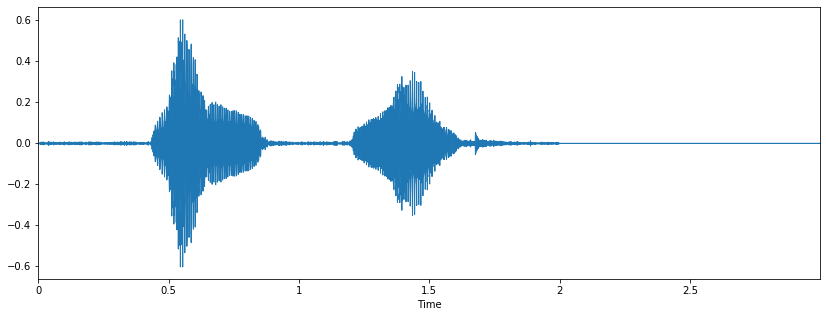

In [37]:
samples, sr = librosa.load('slicingShowcase/test.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sr)
HandleAudioBuffer()

### Das erste Wort

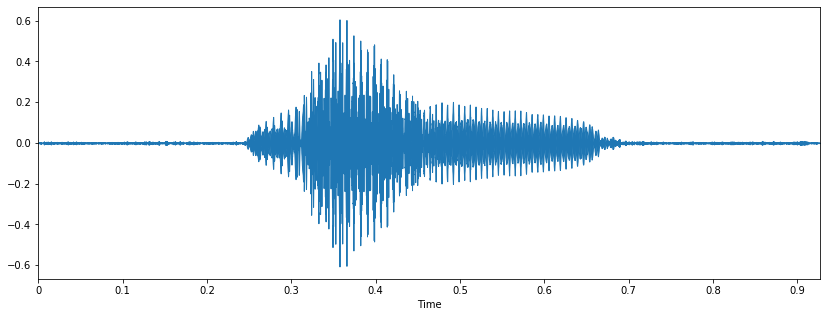

In [38]:
samples, sr = librosa.load('slicingShowcase/first.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sr)

### Das zweite Wort

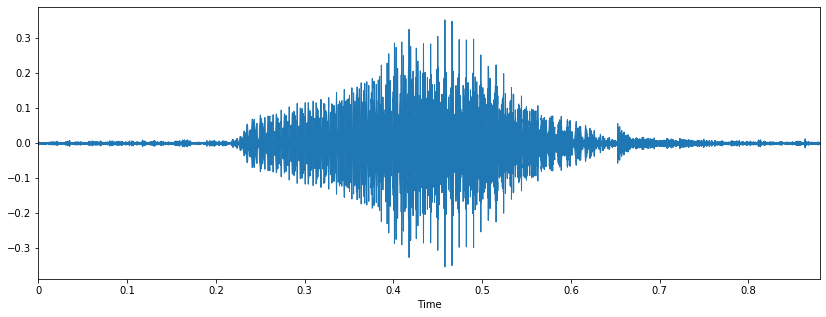

In [36]:
samples, sr = librosa.load('slicingShowcase/second.wav')
plt.figure(figsize=(14, 5))
librosa.display.waveplot(samples, sr=sr)

## Melspektogram


### Show Image
Die Funktion show(image,title = None) ermöglicht das Plotten von Bildern. Das Argument title ist optional und kann z.B. für das entsprechende Label verwendet werden.

In [61]:
def show(_image,_title = None):
    plt.figure(figsize=(15, 5))
    plt.imshow(_image)
    if _title is not None:
        plt.title(_title)
    plt.colorbar()
    plt.show()

### Convert to Image
Die funktion konvertiert eine .wav-Datei zu einem MelSpektrogram in Form eines Arrays.
Das Melspektrogram ist in der Spracherkennung besonders wichtig. 
Für weitere Information, findet man in der Doku eine genauere erklärung zum Spektrogram.

In [62]:
def wave2image(file):

    samples, sample_rate = librosa.core.load(file,sr=16000)

    # Audio Manipulation
    #samples = manipulateAmplitude(samples, (0.7, 1.1))
    #samples = manipulateSpeed(samples, 0.2)
    #samples = backgroundNoise(samples, 0.01)
    #samples = manipulateShift(samples, sample_rate, 0.2)
    #samples = manipulateLength(samples, 0.2)

    # correct length of audiosample to fix length
    fixed_sample_length = int(durationOfAudioSample * sample_rate)
    if fixed_sample_length < len(samples):      #truncate
        samples = samples[:fixed_sample_length]
    elif fixed_sample_length > len(samples):    # add silence
        samples = np.pad(samples, (0, fixed_sample_length - len(samples)), "constant")

    # Create MelSpectrum
    s = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=32)
    mel = librosa.power_to_db(s, ref=np.max)
    return mel

### Geplottete Audiospuren

Hier kann man einmal das Melspektrogram der gesamten Datei sehen und dann der beiden einzelnen Wörter.


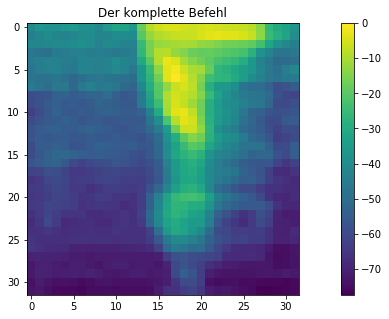

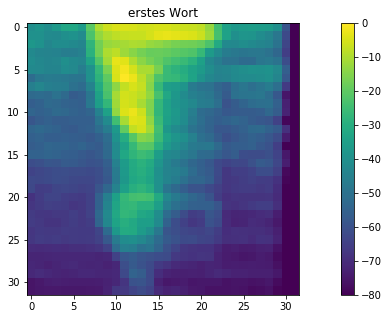

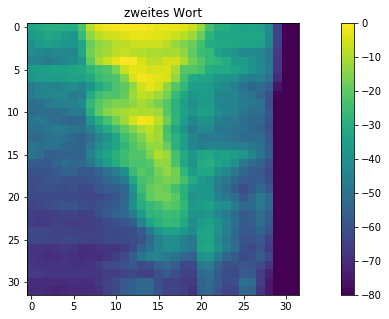

In [66]:
durationOfAudioSample = 1
sentenceImg = wave2image('slicingShowcase/test.wav')
firstWordImg = wave2image('slicingShowcase/first.wav')
secondWordImg = wave2image('slicingShowcase/second.wav')
show(sentenceImg, "Der komplette Befehl")
show(firstWordImg, "erstes Wort")
show(secondWordImg, "zweites Wort")